# **SMAI Assignment - 1**
##### (Monsoon 2023-24)

> **Name**: *Bhav Beri*
> 
> **Roll Number**: *2021111013*

## Imports

In [1]:
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from itertools import chain, combinations

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, hamming_loss, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier as dtc


## Configs

In [3]:
random_state = 42

#### Part - A

In [2]:
dataset_file = './data.npy'
max_k = 15

In [4]:
possible_distance_metrics = ["euclidean", "manhattan", "cosine"]
possible_weights = ["uniform", "distance"]
possible_encodings = ["resnet", "vit"]

In [5]:
run_distance_metrics = ["euclidean", "manhattan", "cosine"]
run_weights = ["uniform", ]
run_encodings = ["resnet", "vit"]

In [6]:
best_model_file_path = "./best_model.pkl"

#### Part - B

In [7]:
dataset_path = "./advertisement.csv"
k_splits = 5

In [8]:
possible_criterion = ["gini", "entropy"]
possible_max_depth = [3,5,10,20,30]
possible_max_features = [3,5,7,9,11]

## Utils

#### Part - A

In [9]:
def euclidean_dist(pointA, pointB):
    sum = np.sum((pointA - pointB) ** 2)
    return np.sqrt(sum)

def manhattan_dist(pointA, pointB):
    return np.sum(np.abs(pointA - pointB))

def cosine_dist(pointA, pointB):
    return 1 - np.dot(pointA[0], pointB[0]) / (np.linalg.norm(pointA[0]) * np.linalg.norm(pointB[0]))

In [10]:
class KNN():
    def __init__(self, k: int, distance_metrics: str = "euclidean", weights: str = "uniform", encoder: str = "ResNet"):
        assert k > 0, "k must be greater than 0"
        self.k = k

        assert distance_metrics.lower() in possible_distance_metrics, "invalid distance_metrics"
        self.distance_metrics = distance_metrics.lower()
        if self.distance_metrics == "euclidean":
            self.dist_func = euclidean_dist
        elif self.distance_metrics == "manhattan":
            self.dist_func = manhattan_dist
        elif self.distance_metrics == "cosine":
            self.dist_func = cosine_dist

        assert weights.lower() in possible_weights, "invalid weights"
        self.weights = weights.lower()

        assert encoder.lower() in possible_encodings, "invalid encoder"
        self.encoder = encoder.lower()

        self.train_data = list()
        self.train_label = list()

    def fit(self, dataset):
        if self.encoder == "resnet":
            self.train_data = dataset[:,1]
        elif self.encoder == "vit":
            self.train_data = dataset[:,2]
        
        self.train_label = dataset[:,3]
    
    def predict(self, test_data):
        assert len(self.train_data) > 0, "train_data is empty"
        assert len(self.train_label) > 0, "train_label is empty"

        pred = list()
        encoder_test_data = list()
        if self.encoder == "resnet":
            encoder_test_data = test_data[:,1]
        elif self.encoder == "vit":
            encoder_test_data = test_data[:,2]
        for test in encoder_test_data:
            dist = np.array([self.dist_func(test, train) for train in self.train_data])
            idx = np.argsort(dist) # Get sorting index list

            k_labels = self.train_label[idx][:self.k]

            # Written with help from GitHub Copilot
            if self.weights == "uniform":
                unique_labels, label_counts = np.unique(k_labels, return_counts=True)
                pred.append(unique_labels[np.argmax(label_counts)])
            elif self.weights == "distance":
                k_dist = dist[idx][:self.k]
                weights = 1 / k_dist
                unique_labels, label_weights = np.unique(k_labels, return_inverse=True)
                weighted_counts = np.bincount(label_weights, weights=weights)
                pred.append(unique_labels[np.argmax(weighted_counts)])
                # label_weights = np.bincount(k_labels, weights=weights, minlength=np.max(k_labels) + 1)
                # pred.append(np.argmax(label_weights))
        return pred
    
    def scoring(self, actual_labels, pred_labels):
        f1 = f1_score(actual_labels, pred_labels, zero_division=0, average='weighted')
        accuracy = accuracy_score(actual_labels, pred_labels)
        precision = precision_score(actual_labels, pred_labels, zero_division=0, average='weighted')
        recall = recall_score(actual_labels, pred_labels, zero_division=0, average='weighted')

        # Return a dictionary of scores rounded off to 4 decimal places
        return {'f1': round(f1, 4), 'accuracy': round(accuracy, 4), 'precision': round(precision, 4), 'recall': round(recall, 4)}

#### Part - B

In [11]:
def encode_columns(df, columns):
    encoders = {}
    for col in columns:
        le = LabelEncoder().fit(df[col])
        df[col] = le.transform(df[col])
        encoders[col] = le
    return df, encoders

In [12]:
def get_unique_labels(df_column):
    s = set()
    labels = list(map(lambda x: x.split(), df_column))
    for label in labels:
        s.update(label)
    return list(s)

In [13]:
def getDifference(a,p):
    symmetric_diff = []

    for row1, row2 in zip(a,p):
        diff_row = list(set(row1).symmetric_difference(row2))
        symmetric_diff.append(diff_row)

    return sum(len(sublist)/len(a) for sublist in symmetric_diff)

In [14]:
def powerset(iterable):
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))

In [15]:
def decimalListToBinaryList(l):
    result = []
    for i in l:
        s = bin(i).replace("0b", "")
        s = "0"*(8-len(s))+s
        result.append(list(map(int,list(s))))
    return result


In [16]:
class DT_Powerset():
    def __init__(self, all_labels, max_depth=None, max_features=None, criterion="gini"):
        assert criterion in possible_criterion
        
        self.data = None
        self.labels = None

        self.all_labels = get_unique_labels(all_labels)
        powerset_labels = list(map(lambda x: " ".join(sorted(x)), powerset(self.all_labels)))
        self.label_encoder = LabelEncoder().fit(powerset_labels)

        self.dt = dtc(max_depth=max_depth, max_features=max_features, criterion=criterion)

    def encode_labels(self, labels):
        labels = list(map(lambda x: " ".join(sorted(x.split())), labels))
        return self.label_encoder.transform(labels)
    
    def decode_labels(self, labels):
        return self.label_encoder.inverse_transform(labels)
    
    def fit(self, data, labels):
        assert data.shape[0] == labels.shape[0]

        self.data = np.array(data)
        self.labels = self.encode_labels(labels)
        self.dt.fit(self.data, self.labels)

    def predict(self, data):
        data = np.array(data)
        return self.decode_labels(self.dt.predict(data))
    
    def scoring(self, actual_labels, pred_labels):
        actual_labels = list(actual_labels)
        pred_labels = list(pred_labels)
        
        pred_labels = list(map(lambda x: " ".join(sorted(x.split())), pred_labels))

        accuracy_macro = sum(np.array(actual_labels) == np.array(pred_labels)) / len(actual_labels)

        actual_labels = decimalListToBinaryList(self.encode_labels(actual_labels))
        pred_labels = decimalListToBinaryList(self.encode_labels(pred_labels))
        accuracy_micro = 1-hamming_loss(actual_labels, pred_labels)

        f1_micro = f1_score(actual_labels, pred_labels, average="micro")
        f1_macro = f1_score(actual_labels, pred_labels, average="macro")

        precision_score_micro = precision_score(actual_labels, pred_labels, average="micro", zero_division=0)
        precision_score_macro = precision_score(actual_labels, pred_labels, average="macro", zero_division=0)

        recall_score_micro = recall_score(actual_labels, pred_labels, average="micro", zero_division=0)
        recall_score_macro = recall_score(actual_labels, pred_labels, average="macro", zero_division=0)

        cf_matrix = multilabel_confusion_matrix(actual_labels, pred_labels)

        scores = {
            "accuracy_micro": accuracy_micro,
            "accuracy_macro": accuracy_macro,
            "f1_micro": f1_micro,
            "f1_macro": f1_macro,
            "precision_score_micro": precision_score_micro,
            "precision_score_macro": precision_score_macro,
            "recall_score_micro": recall_score_micro,
            "recall_score_macro": recall_score_macro,
            "cf_matrix": cf_matrix
        }

        return scores

In [17]:
class DT_MultiOutput():
    def __init__(self, all_labels, max_depth=None, max_features=None, criterion="gini"):
        assert criterion in ["gini", "entropy"]
        
        self.data = None
        self.labels = None

        self.all_labels = get_unique_labels(all_labels)
        self.label_encoder = MultiLabelBinarizer().fit([self.all_labels,])

        self.dts = {}
        for label in self.all_labels:
            self.dts[label] = dtc(max_depth=max_depth, max_features=max_features, criterion=criterion)

    def encode_labels(self, labels):        
        labels = list(map(lambda x: x.split(), labels))
        return self.label_encoder.transform(labels)
    
    def decode_labels(self, labels):
        labels = np.array(labels)
        return list(self.label_encoder.inverse_transform(labels))
    
    def fit(self, data, labels):
        assert data.shape[0] == labels.shape[0]

        self.data = data
        self.labels = self.encode_labels(labels)

        for i, label in enumerate(self.all_labels):
            self.dts[label].fit(self.data, self.labels[:,i])

    def predict(self, data):
        pred_labels = []
        for i, label in enumerate(self.all_labels):
            pred_labels.append(np.array(self.dts[label].predict(data)))
        
        pred_labels = np.array(pred_labels).T

        return self.decode_labels(pred_labels)
    
    def scoring(self, actual_labels, pred_labels):
        actual_labels = list(actual_labels)
        pred_labels = list(pred_labels)
        pred_labels = list(map(lambda x: " ".join(sorted(x)), pred_labels))

        accuracy_macro = sum(np.array(actual_labels) == np.array(pred_labels)) / len(actual_labels)

        actual_labels = self.encode_labels(actual_labels)
        pred_labels = self.encode_labels(pred_labels)

        accuracy_micro = 1-hamming_loss(actual_labels, pred_labels)

        f1_micro = f1_score(actual_labels, pred_labels, average="micro")
        f1_macro = f1_score(actual_labels, pred_labels, average="macro")

        precision_score_micro = precision_score(actual_labels, pred_labels, average="micro", zero_division=0)
        precision_score_macro = precision_score(actual_labels, pred_labels, average="macro", zero_division=0)

        recall_score_micro = recall_score(actual_labels, pred_labels, average="micro", zero_division=0)
        recall_score_macro = recall_score(actual_labels, pred_labels, average="macro", zero_division=0)

        cf_matrix = multilabel_confusion_matrix(actual_labels, pred_labels)

        scores = {
            "accuracy_micro": accuracy_micro,
            "accuracy_macro": accuracy_macro,
            "f1_micro": f1_micro,
            "f1_macro": f1_macro,
            "precision_score_micro": precision_score_micro,
            "precision_score_macro": precision_score_macro,
            "recall_score_micro": recall_score_micro,
            "recall_score_macro": recall_score_macro,
            "cf_matrix": cf_matrix
        }

        return scores

## Main Code

#### Part - A

Dataset Shape -  (1500, 5)
Data row shape (5,)
Max Frequency Label: flute with Value = 26
Min Frequency Label: dig with Value = 1


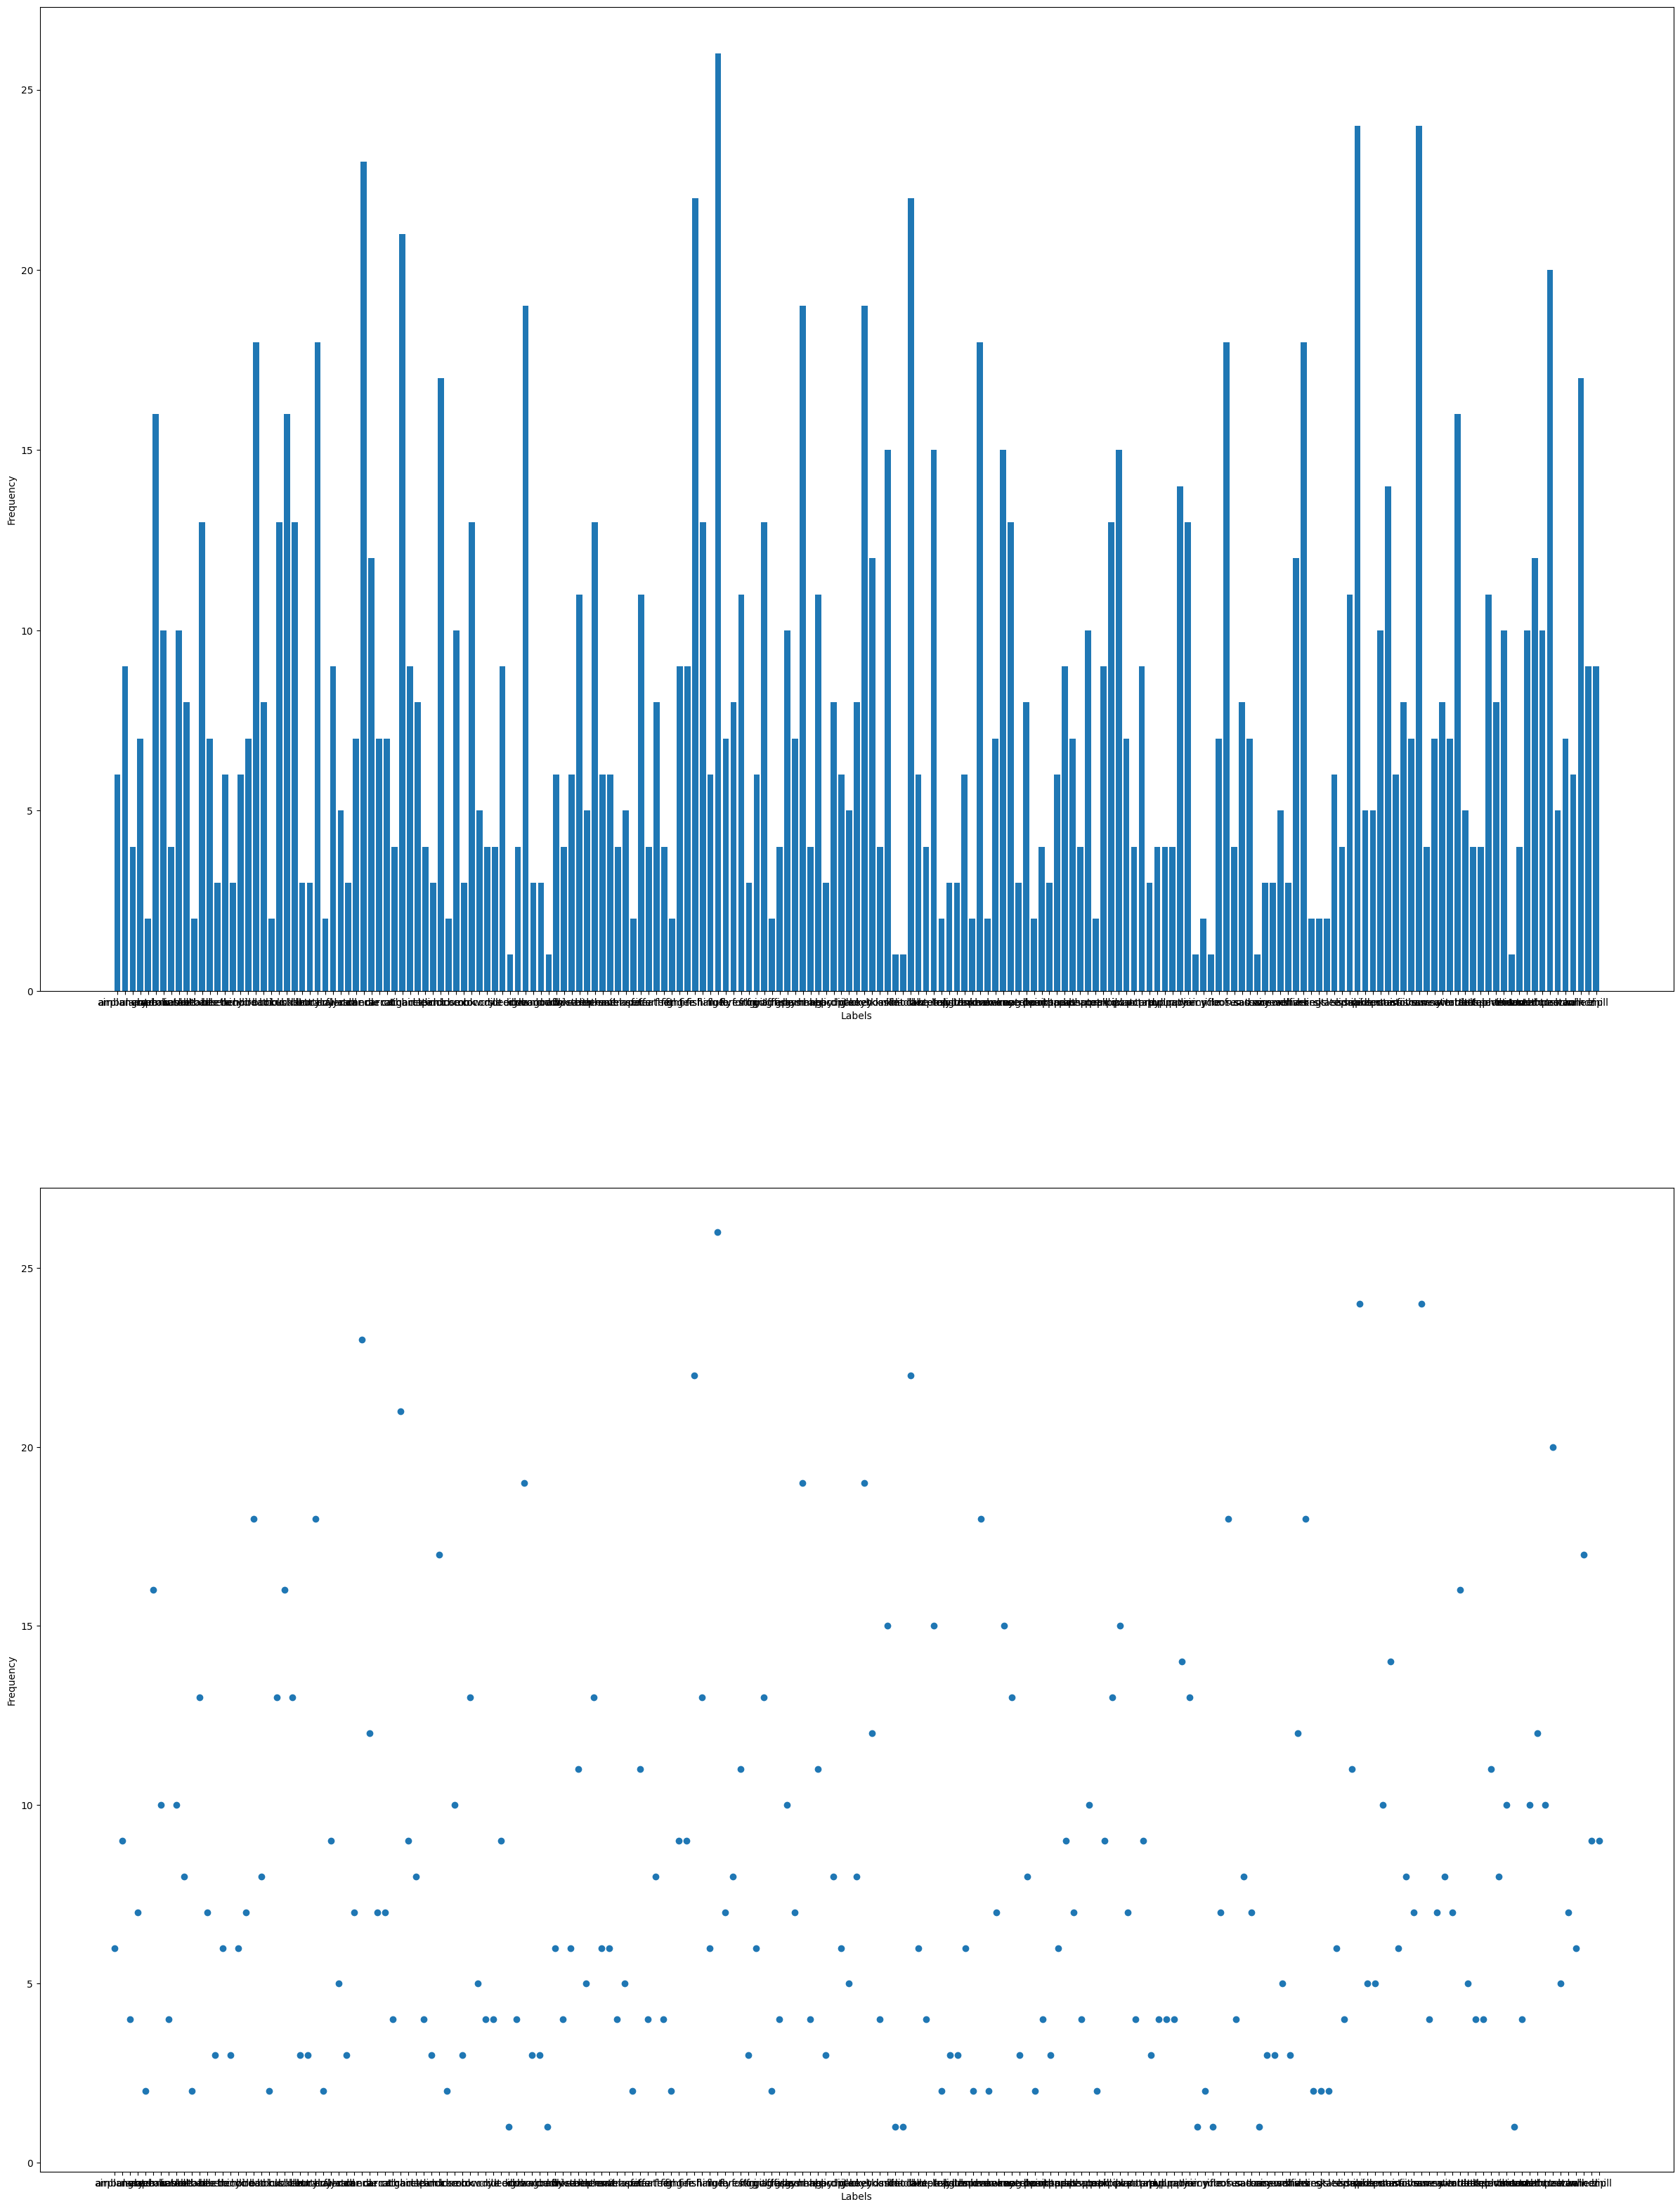

In [18]:
data = np.array(np.load(dataset_file, allow_pickle=True))

print("Dataset Shape - ", data.shape)
print("Data row shape",data[0].shape)

labels = data[:,3]
labels_frequency = dict()

for label in np.unique(labels):
    labels_frequency[label] = np.sum(labels == label)

print("Max Frequency Label:", max(labels_frequency, key=labels_frequency.get), "with Value =", max(labels_frequency.values()))
print("Min Frequency Label:", min(labels_frequency, key=labels_frequency.get), "with Value =", min(labels_frequency.values()))       

fig, axs = plt.subplots(2,1, figsize=(30, 40))

axs[0].bar(list(labels_frequency.keys()), list(labels_frequency.values()))
axs[0].set_xlabel('Labels')
axs[0].set_ylabel('Frequency')

axs[1].scatter(list(labels_frequency.keys()), list(labels_frequency.values()))
axs[1].set_xlabel('Labels')
axs[1].set_ylabel('Frequency')
plt.show()

In [19]:
# Prepare Data

data_train, data_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=random_state)

In [20]:
# Get all possible combinations of hyperparameters
all_scores = list()

for k in range(1, max_k + 1):
    for distance_metrics in run_distance_metrics:
        for weights in run_weights:
            for encoder in run_encodings:
                print("k =", k, "| distance_metrics =", distance_metrics, "| weights =", weights, "| encoder =", encoder)
                knn = KNN(k=k, distance_metrics=distance_metrics, weights=weights, encoder=encoder)
                knn.fit(data_train)
                start = time.time()
                pred = knn.predict(data_test)
                end = time.time()
                score = knn.scoring(y_test, pred)
                time_taken = end - start
                print("Time:", time_taken, "s")
                print("Score:", score)
                print("")
                score["time"] = time_taken
                all_scores.append([score, k, distance_metrics, weights, encoder])

k = 1 | distance_metrics = euclidean | weights = uniform | encoder = resnet
Time: 2.8203680515289307 s
Score: {'f1': 0.1838, 'accuracy': 0.1867, 'precision': 0.2191, 'recall': 0.1867}

k = 1 | distance_metrics = euclidean | weights = uniform | encoder = vit
Time: 2.589452028274536 s
Score: {'f1': 0.2552, 'accuracy': 0.27, 'precision': 0.2778, 'recall': 0.27}

k = 1 | distance_metrics = manhattan | weights = uniform | encoder = resnet
Time: 2.5939207077026367 s
Score: {'f1': 0.1846, 'accuracy': 0.1867, 'precision': 0.2186, 'recall': 0.1867}

k = 1 | distance_metrics = manhattan | weights = uniform | encoder = vit
Time: 2.039295196533203 s
Score: {'f1': 0.2633, 'accuracy': 0.2767, 'precision': 0.3037, 'recall': 0.2767}

k = 1 | distance_metrics = cosine | weights = uniform | encoder = resnet
Time: 3.2477853298187256 s
Score: {'f1': 0.197, 'accuracy': 0.2033, 'precision': 0.24, 'recall': 0.2033}

k = 1 | distance_metrics = cosine | weights = uniform | encoder = vit
Time: 3.452729463577270

In [21]:
# Sort the combinations based on accuracy score
all_scores.sort(key=lambda x: x[0]["accuracy"], reverse=True)

In [22]:
# Best Model

best_model = KNN(k=all_scores[0][1], distance_metrics=all_scores[0][2], weights=all_scores[0][3], encoder=all_scores[0][4])
best_model.fit(data_train)

fp = open(best_model_file_path, "wb+")
pickle.dump(best_model, fp)
fp.close()

print("Best Triplet:")
print("k =", all_scores[0][1], "distance_metrics =", all_scores[0][2], "weights =", all_scores[0][3], "encoder =", all_scores[0][4])
print("Score:", all_scores[0][0])

Best Triplet:
k = 1 distance_metrics = manhattan weights = uniform encoder = vit
Score: {'f1': 0.2633, 'accuracy': 0.2767, 'precision': 0.3037, 'recall': 0.2767, 'time': 2.039295196533203}


In [23]:
# Check the Best Model Saved

fp = open(best_model_file_path, "rb")
best_model = pickle.load(fp)
fp.close()

pred = best_model.predict(data_test)
scores = best_model.scoring(y_test, pred)
old_scores = all_scores[0][0].copy()
del old_scores['time']

print(scores == old_scores)

True


In [24]:
# Top 20 triplets in a table format

print("Top 20 Triplets:")

print(all_scores[0][0])

x = PrettyTable()
x.field_names = ["Rank", "k", "distance_metrics", "weights", "encoder", "accuracy", "f1", "precision", "recall", "time"]
x.add_rows([[i+1, all_scores[i][1], all_scores[i][2], all_scores[i][3], all_scores[i][4], all_scores[i][0]["accuracy"], all_scores[i][0]["f1"], all_scores[i][0]["precision"], all_scores[i][0]["recall"], all_scores[i][0]["time"]] for i in range(20)])
print(x)

Top 20 Triplets:
{'f1': 0.2633, 'accuracy': 0.2767, 'precision': 0.3037, 'recall': 0.2767, 'time': 2.039295196533203}
+------+----+------------------+---------+---------+----------+--------+-----------+--------+--------------------+
| Rank | k  | distance_metrics | weights | encoder | accuracy |   f1   | precision | recall |        time        |
+------+----+------------------+---------+---------+----------+--------+-----------+--------+--------------------+
|  1   | 1  |    manhattan     | uniform |   vit   |  0.2767  | 0.2633 |   0.3037  | 0.2767 | 2.039295196533203  |
|  2   | 1  |    euclidean     | uniform |   vit   |   0.27   | 0.2552 |   0.2778  |  0.27  | 2.589452028274536  |
|  3   | 1  |      cosine      | uniform |   vit   |   0.26   | 0.244  |   0.2604  |  0.26  | 3.4527294635772705 |
|  4   | 12 |    manhattan     | uniform |   vit   |   0.26   | 0.2305 |   0.268   |  0.26  | 2.4136385917663574 |
|  5   | 13 |    manhattan     | uniform |   vit   |  0.2533  | 0.2193 |   0.

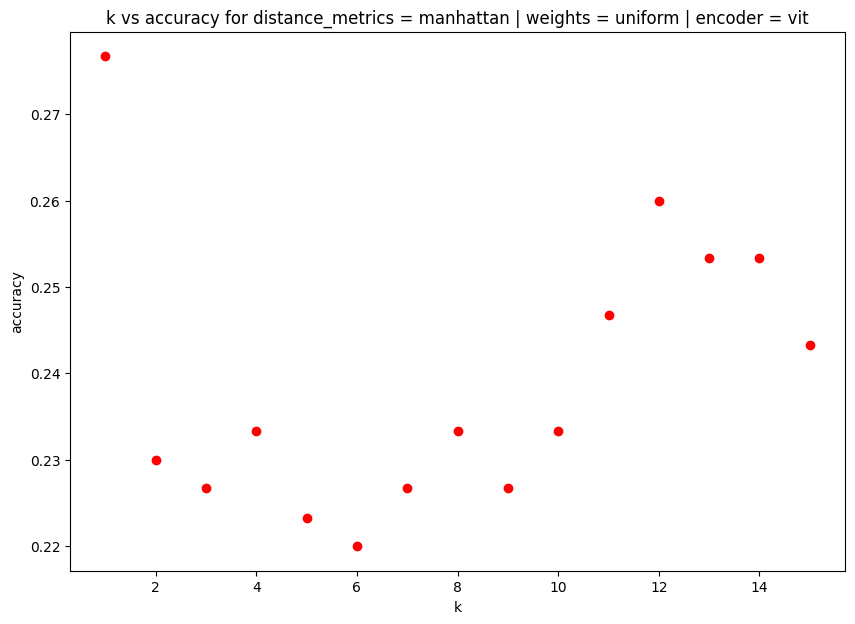

In [25]:
# Plot k vs accuracy for a fixed distance_metrics, weights and encoder

encoder = "vit"
distance_metrics = "manhattan"
weights = "uniform"
k = [all_scores[i][1] for i in range(len(all_scores)) if all_scores[i][2] == distance_metrics and all_scores[i][3] == weights and all_scores[i][4] == encoder]
accuracy = [all_scores[i][0]["accuracy"] for i in range(len(all_scores)) if all_scores[i][2] == distance_metrics and all_scores[i][3] == weights and all_scores[i][4] == encoder]

plt.figure(figsize=(10, 7))
plt.scatter(k, accuracy, color='red')
plt.xlabel("k")
plt.ylabel("accuracy")
plt.title("k vs accuracy for distance_metrics = " + distance_metrics + " | weights = " + weights + " | encoder = " + encoder)
plt.show()

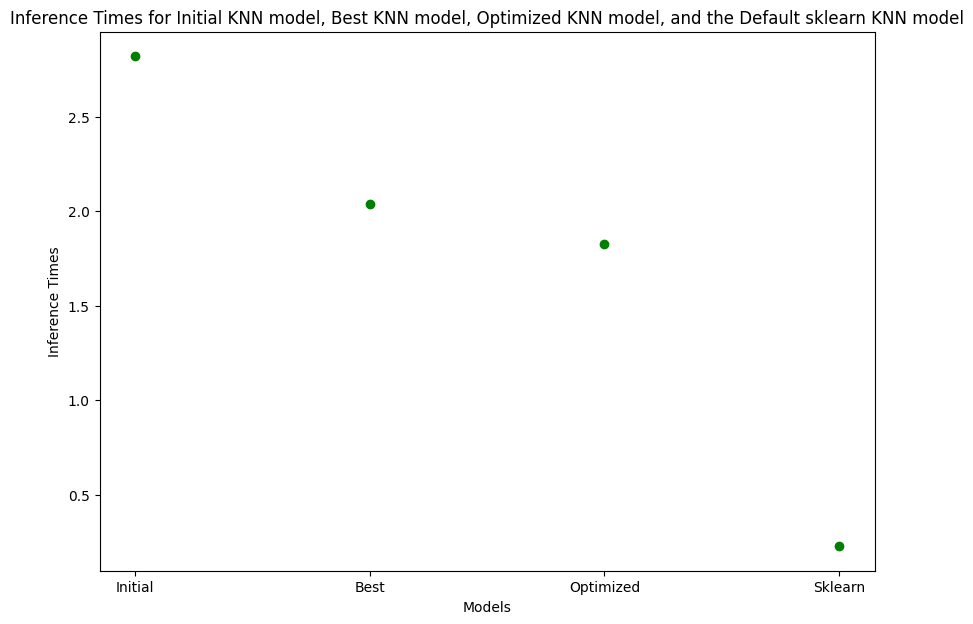

In [26]:
# Plot inference time for initial KNN model, best KNN model, most optimized KNN model, and the default sklearn KNN model

# Best KNN model
best_inference_time = all_scores[0][0]["time"]

# Sort the combinations based on time
all_scores_copy = all_scores.copy()
all_scores_copy.sort(key=lambda x: x[0]["time"])
optimized_inference_time = all_scores_copy[0][0]["time"]
optimized_model = KNN(k=all_scores_copy[0][1], distance_metrics=all_scores_copy[0][2], weights=all_scores_copy[0][3], encoder=all_scores_copy[0][4])

# Initial KNN model
initial_model = KNN(k=1, distance_metrics="euclidean", weights="uniform", encoder="resnet")
initial_inference_time = 0
for elem in all_scores:
    if elem[1] == 1 and elem[2] == "euclidean" and elem[3] == "uniform" and elem[4] == "resnet":
        initial_inference_time = elem[0]["time"]
        break

# Default sklearn KNN model
data_train_vit, data_test_vit = [],[]

for i in data_train:
    data_train_vit.append(i[2].reshape(-1))

for i in data_test:
    data_test_vit.append(i[2].reshape(-1))

knn = KNeighborsClassifier(n_neighbors=all_scores[0][1])
knn.fit(data_train_vit, y_train) # type: ignore
start = time.time()
pred = knn.predict(data_test_vit) # type: ignore
end = time.time()
sklearn_inference_time = end - start

classes = ['Initial', 'Best', 'Optimized', 'Sklearn']
inference_times = [initial_inference_time, best_inference_time, optimized_inference_time, sklearn_inference_time]

plt.figure(figsize=(10, 7))
plt.scatter(classes, inference_times, color='green')
plt.xlabel("Models")
plt.ylabel("Inference Times")
plt.title("Inference Times for Initial KNN model, Best KNN model, Optimized KNN model, and the Default sklearn KNN model")
plt.show()

In [27]:
x = []
best_inference_times = []
optimized_inference_times = []
initial_inference_times = []
sklearn_inference_times = []

for i in range(1, data_train.shape[0]+1, 100):
    best_model.fit(data_train[:i])
    optimized_model.fit(data_train[:i])
    initial_model.fit(data_train[:i])

    data_train_vit, data_test_vit = [],[]
    y_train_vit = [i[3] for i in data_train[:i]]

    for j in data_train[:i]:
        data_train_vit.append(j[2].reshape(-1))

    for j in data_test:
        data_test_vit.append(j[2].reshape(-1))

    knn = KNeighborsClassifier(n_neighbors=all_scores[0][1])
    knn.fit(data_train_vit, y_train_vit) # type: ignore

    # Calculate Times
    start = time.time()
    pred = best_model.predict(data_test)
    end = time.time()
    best_inference_time = end - start

    start = time.time()
    pred = optimized_model.predict(data_test)
    end = time.time()
    optimized_inference_time = end - start

    start = time.time()
    pred = initial_model.predict(data_test)
    end = time.time()
    initial_inference_time = end - start

    start = time.time()
    pred = knn.predict(data_test_vit) # type: ignore
    end = time.time()
    sklearn_inference_time = end - start

    x.append(i)
    best_inference_times.append(best_inference_time)
    optimized_inference_times.append(optimized_inference_time)
    initial_inference_times.append(initial_inference_time)
    sklearn_inference_times.append(sklearn_inference_time)


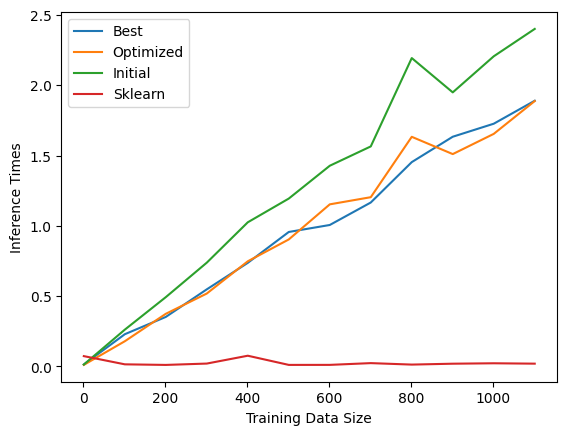

In [28]:
plt.plot(x, best_inference_times, label="Best")
plt.plot(x, optimized_inference_times, label="Optimized")
plt.plot(x, initial_inference_times, label="Initial")
plt.plot(x, sklearn_inference_times, label="Sklearn")
plt.xlabel("Training Data Size")
plt.ylabel("Inference Times")
plt.legend()
plt.show()

#### Part - B

In [29]:
dataset=pd.read_csv(dataset_path)

In [30]:
print(dataset.shape, dataset.size)

(1000, 11) 11000


In [31]:
# Dataset Sample Values
print(dataset.head())

   age  gender        income    education  married  children           city  \
0   45    Male  61271.953359       Master    False         3    Lake Sheila   
1   24  Female  53229.101074  High School    False         1   Crystalburgh   
2   45  Female  30066.046684     Bachelor     True         3  Margaretburgh   
3   19    Male  48950.246384          PhD    False         0  Williamshaven   
4   29  Female  44792.627094       Master    False         0       New Paul   

    occupation  purchase_amount most bought item  \
0       Doctor        87.697118          monitor   
1  Businessman       115.135586         lipstick   
2     Engineer       101.694559         biscuits   
3       Lawyer        97.964887            maggi   
4  Businessman        86.847281           carpet   

                             labels  
0       electronics clothing sports  
1                  furniture beauty  
2  clothing electronics food sports  
3                              food  
4                     

In [32]:
print(dataset.describe())
print(dataset.info())

               age        income     children  purchase_amount
count  1000.000000   1000.000000  1000.000000      1000.000000
mean     40.836000  49349.796167     1.508000       101.098170
std      13.786848   9894.479148     1.129253        20.348736
min      18.000000  21908.867759     0.000000        23.482179
25%      28.000000  42577.352034     0.000000        87.699577
50%      41.000000  48993.757137     1.000000       101.587560
75%      53.000000  56566.795992     3.000000       114.718926
max      64.000000  79459.294416     3.000000       168.978628
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1000 non-null   int64  
 1   gender            1000 non-null   object 
 2   income            1000 non-null   float64
 3   education         1000 non-null   object 
 4   married           1000 non-null   bool  

In [33]:
print("Education Values:", len(dataset['education'].unique()))
print(dataset['education'].value_counts())
print("City Values:", len(dataset['city'].unique()))
print("Occupaion Values:", len(dataset['occupation'].unique()))
print(dataset['occupation'].value_counts())
print("Most Bought items:", len(dataset['most bought item'].unique()))
print("Labels:", len(dataset['labels'].unique()))

Education Values: 4
education
Master         269
PhD            252
High School    240
Bachelor       239
Name: count, dtype: int64
City Values: 969
Occupaion Values: 11
occupation
Scientist      104
HR             102
Lawyer          95
Unemployed      95
Businessman     93
Engineer        91
Artist          88
Retired         88
Salesman        85
Housewife       82
Doctor          77
Name: count, dtype: int64
Most Bought items: 24
Labels: 397


Columns of the dataset are as follows:

1. age - int
2. gender - Male/Female
3. income - float
4. education - string
5. married - True/False
6. children - int
7. city - string
8. occupation - string
9. purchase_amount - float
10. most bought item - string
- labels - string (Multi-class classification)

In [34]:
colums_to_encode = ['gender', 'married', "education", "occupation", "city", "most bought item"]
dataset_copy = dataset.copy(deep=True)
encoded_data, encoders = encode_columns(dataset_copy, colums_to_encode)
encoded_data.drop(['labels'], axis=1, inplace=True)

In [35]:
print(encoded_data.head())

   age  gender        income  education  married  children  city  occupation  \
0   45       1  61271.953359          2        0         3   366           2   
1   24       0  53229.101074          1        0         1    98           1   
2   45       0  30066.046684          0        1         3   403           3   
3   19       1  48950.246384          3        0         0   959           6   
4   29       0  44792.627094          2        0         0   521           1   

   purchase_amount  most bought item  
0        87.697118                16  
1       115.135586                13  
2       101.694559                 3  
3        97.964887                14  
4        86.847281                 4  


In [36]:
X_train, X_test, y_train, y_test = train_test_split(encoded_data, dataset['labels'], test_size=0.2, random_state=random_state)

In [37]:
# dt = DT_Powerset(dataset['labels'], max_depth=3, max_features=3, criterion="gini")
# dt.fit(X_train, y_train)
# y_pred = dt.predict(X_test)
# scores = dt.scoring(y_test, y_pred)
# print(scores)

In [38]:
# dt = DT_MultiOutput(dataset['labels'], max_depth=3, max_features=3, criterion="gini")
# dt.fit(X_train, y_train)

# y_pred = dt.predict(X_test)
# scores = dt.scoring(y_test, y_pred)
# print(scores)

In [39]:
all_scores_powerset = []
all_scores_multioutput = []

for criterion in possible_criterion:
    for max_depth in possible_max_depth:
        for max_features in possible_max_features:
            dt = DT_Powerset(dataset['labels'], max_depth=max_depth, max_features=max_features, criterion=criterion)
            dt.fit(X_train, y_train)
            score = dt.scoring(y_test, dt.predict(X_test))
            all_scores_powerset.append([criterion, max_depth, max_features, score])

            dt = DT_MultiOutput(dataset['labels'], max_depth=max_depth, max_features=max_features, criterion=criterion)
            dt.fit(X_train, y_train)
            score = dt.scoring(y_test, dt.predict(X_test))
            all_scores_multioutput.append([criterion, max_depth, max_features, score])

In [40]:
# Sort as per F1 scores

all_scores_multioutput = sorted(all_scores_multioutput, key=lambda x: x[3]["f1_micro"], reverse=True)
all_scores_powerset = sorted(all_scores_powerset, key=lambda x: x[3]["f1_micro"], reverse=True)

In [41]:
pt = PrettyTable()
pt.field_names = ["Criterion", "Max Depth", "Max Features", "Accuracy (Hamming)", "Accuracy", "F1 Micro", "F1 Macro", "Precision Score Micro", "Precision Score Macro", "Recall Score Micro", "Recall Score Macro"]
for row in all_scores_powerset:
    pt.add_row(row[:3] + list(row[3].values())[:-1])
print(pt)

+-----------+-----------+--------------+--------------------+----------+--------------------+---------------------+-----------------------+-----------------------+---------------------+---------------------+
| Criterion | Max Depth | Max Features | Accuracy (Hamming) | Accuracy |      F1 Micro      |       F1 Macro      | Precision Score Micro | Precision Score Macro |  Recall Score Micro |  Recall Score Macro |
+-----------+-----------+--------------+--------------------+----------+--------------------+---------------------+-----------------------+-----------------------+---------------------+---------------------+
|  entropy  |     5     |      11      | 0.6325000000000001 |   0.09   | 0.6632302405498283 |  0.6366725808222504 |   0.6835891381345927  |   0.6633225993502109  |  0.6440489432703004 |   0.61798207946333  |
|    gini   |     30    |      5       |      0.61375       |   0.04   | 0.6608122941822174 |  0.648167810127787  |   0.6522210184182016  |   0.6400470898943978  |  0.6

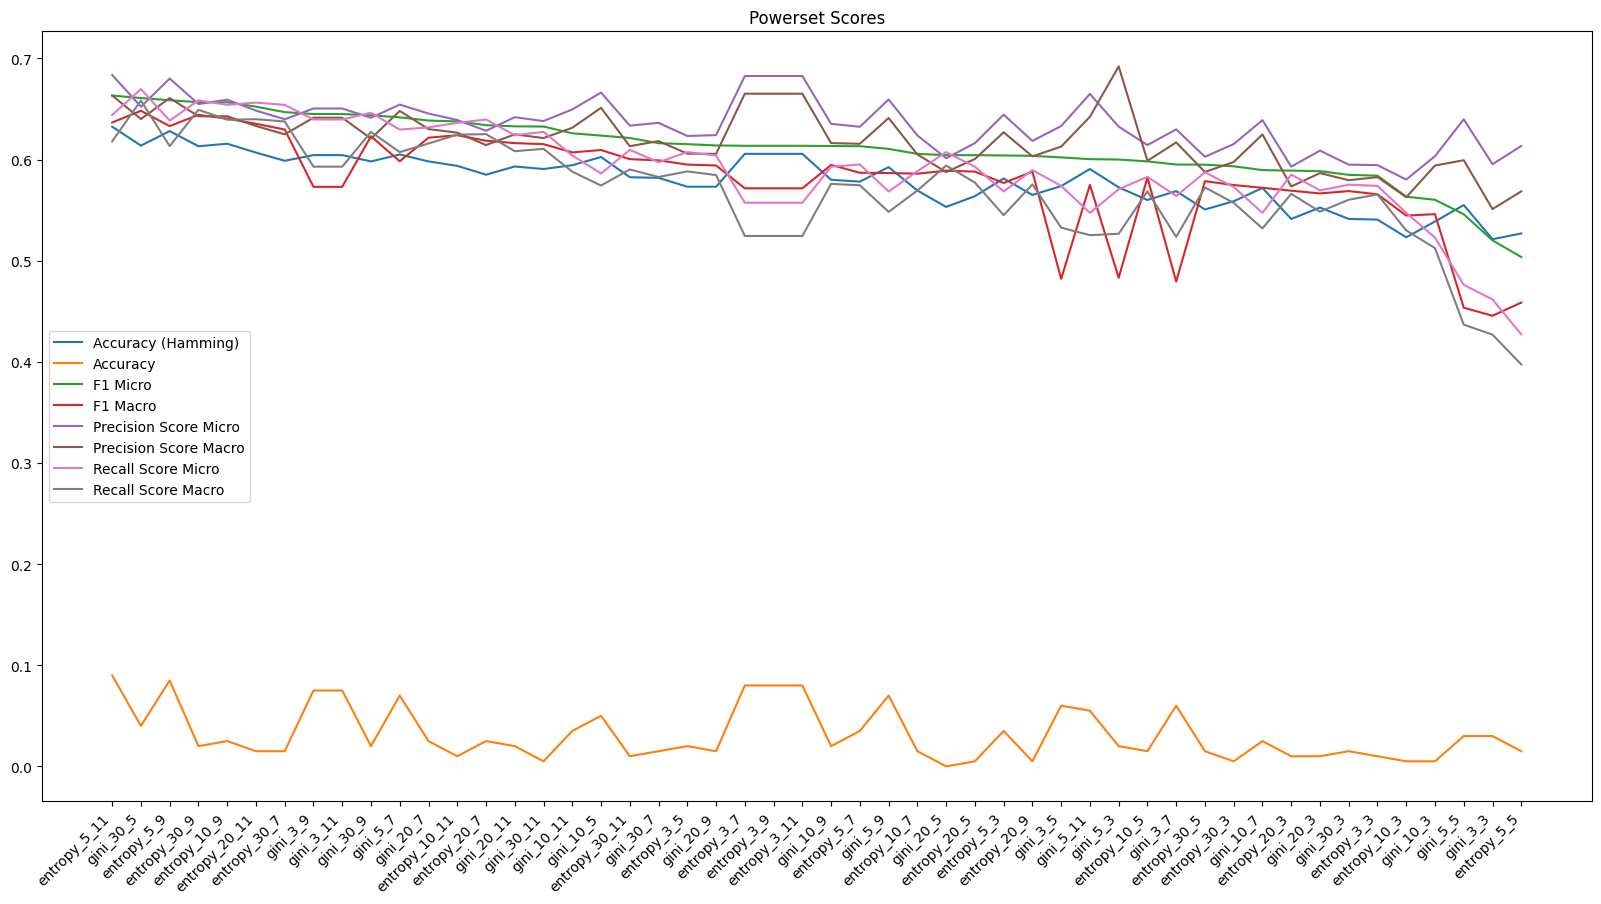

In [42]:
# Plot a graph will all these parameters of scores

x_axis = list(map(lambda x: x[0] + "_" + str(x[1]) + "_" + str(x[2]), all_scores_powerset))

plt.figure(figsize=(20,10))
plt.title("Powerset Scores")
plt.plot(x_axis, list(map(lambda x: x[3]["accuracy_micro"], all_scores_powerset)), label="Accuracy (Hamming)")
plt.plot(x_axis, list(map(lambda x: x[3]["accuracy_macro"], all_scores_powerset)), label="Accuracy")
plt.plot(x_axis, list(map(lambda x: x[3]["f1_micro"], all_scores_powerset)), label="F1 Micro")
plt.plot(x_axis, list(map(lambda x: x[3]["f1_macro"], all_scores_powerset)), label="F1 Macro")
plt.plot(x_axis, list(map(lambda x: x[3]["precision_score_micro"], all_scores_powerset)), label="Precision Score Micro")
plt.plot(x_axis, list(map(lambda x: x[3]["precision_score_macro"], all_scores_powerset)), label="Precision Score Macro")
plt.plot(x_axis, list(map(lambda x: x[3]["recall_score_micro"], all_scores_powerset)), label="Recall Score Micro")
plt.plot(x_axis, list(map(lambda x: x[3]["recall_score_macro"], all_scores_powerset)), label="Recall Score Macro")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.show()

In [43]:
pt = PrettyTable()
pt.field_names = ["Criterion", "Max Depth", "Max Features", "Accuracy (Hamming)", "Accuracy", "F1 Micro", "F1 Macro", "Precision Score Micro", "Precision Score Macro", "Recall Score Micro", "Recall Score Macro"]
for row in all_scores_multioutput:
    pt.add_row(row[:3] + list(row[3].values())[:-1])
print(pt)

+-----------+-----------+--------------+--------------------+----------+---------------------+---------------------+-----------------------+-----------------------+---------------------+---------------------+
| Criterion | Max Depth | Max Features | Accuracy (Hamming) | Accuracy |       F1 Micro      |       F1 Macro      | Precision Score Micro | Precision Score Macro |  Recall Score Micro |  Recall Score Macro |
+-----------+-----------+--------------+--------------------+----------+---------------------+---------------------+-----------------------+-----------------------+---------------------+---------------------+
|    gini   |     10    |      11      |      0.70375       |   0.04   |  0.5297619047619047 |  0.5275798925022006 |   0.5550935550935551  |   0.560419399157122   |  0.5066413662239089 |  0.504464167934584  |
|  entropy  |     10    |      9       |      0.72125       |   0.05   |  0.5255319148936171 |  0.5237362124038463 |   0.5980629539951574  |   0.6050757041152168  |

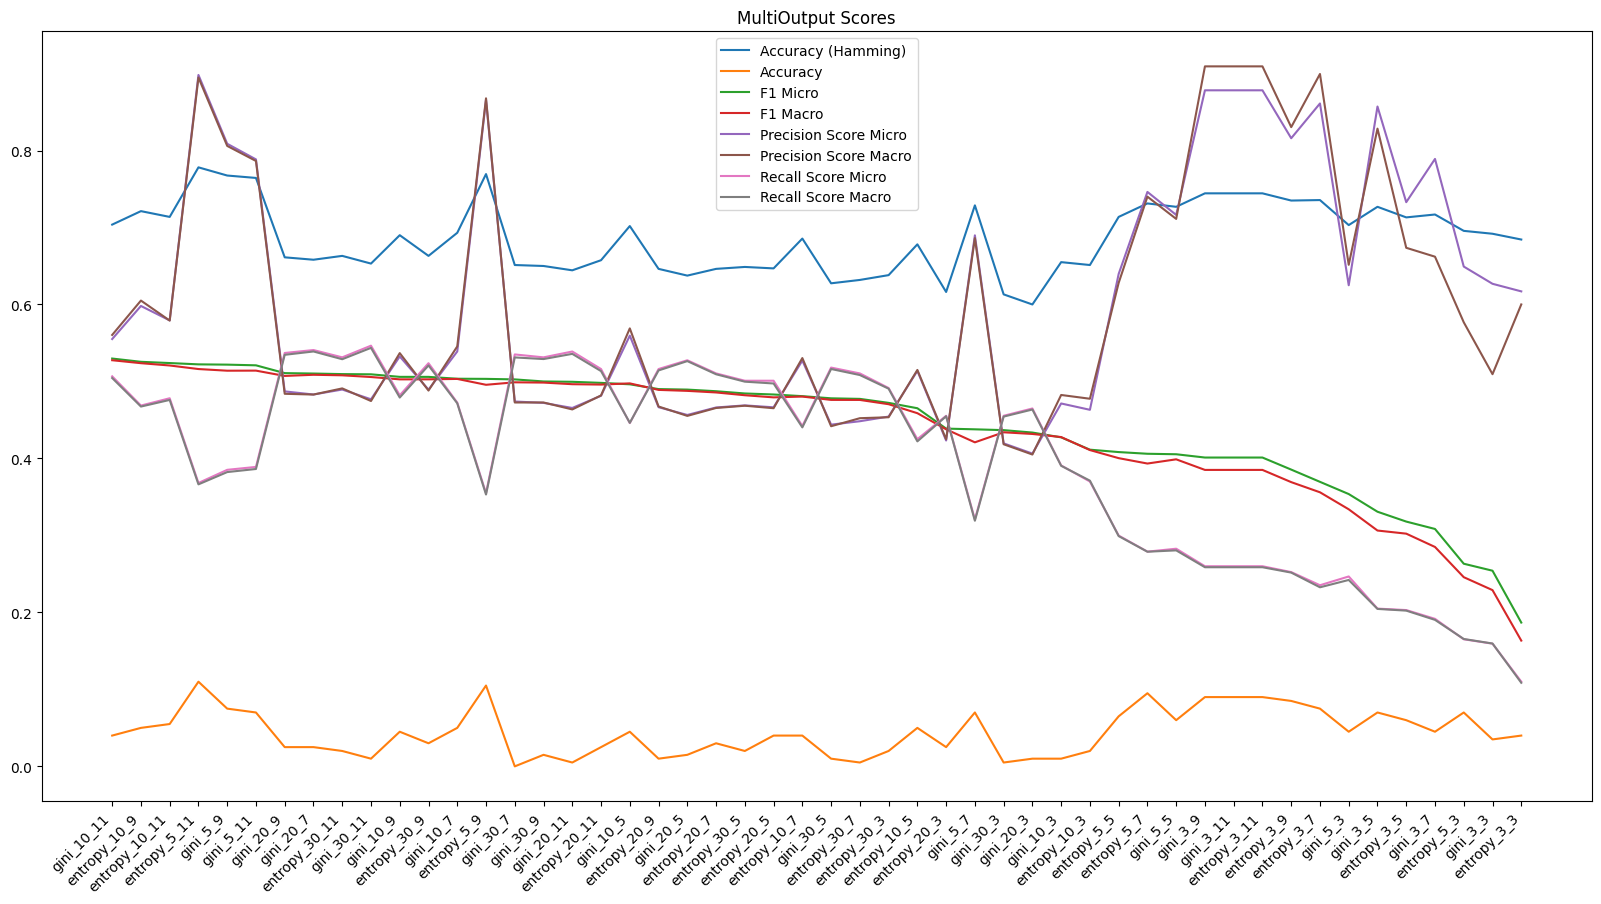

In [44]:
# Plot a graph will all these parameters of scores

x_axis = list(map(lambda x: x[0] + "_" + str(x[1]) + "_" + str(x[2]), all_scores_multioutput))

plt.figure(figsize=(20,10))
plt.title("MultiOutput Scores")
plt.plot(x_axis, list(map(lambda x: x[3]["accuracy_micro"], all_scores_multioutput)), label="Accuracy (Hamming)")
plt.plot(x_axis, list(map(lambda x: x[3]["accuracy_macro"], all_scores_multioutput)), label="Accuracy")
plt.plot(x_axis, list(map(lambda x: x[3]["f1_micro"], all_scores_multioutput)), label="F1 Micro")
plt.plot(x_axis, list(map(lambda x: x[3]["f1_macro"], all_scores_multioutput)), label="F1 Macro")
plt.plot(x_axis, list(map(lambda x: x[3]["precision_score_micro"], all_scores_multioutput)), label="Precision Score Micro")
plt.plot(x_axis, list(map(lambda x: x[3]["precision_score_macro"], all_scores_multioutput)), label="Precision Score Macro")
plt.plot(x_axis, list(map(lambda x: x[3]["recall_score_micro"], all_scores_multioutput)), label="Recall Score Micro")
plt.plot(x_axis, list(map(lambda x: x[3]["recall_score_macro"], all_scores_multioutput)), label="Recall Score Macro")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.show()

In [45]:
print("Top 3 Powerset Scores")

pt = PrettyTable()
pt.field_names = ["Criterion", "Max Depth", "Max Features", "Accuracy (Hamming)", "Accuracy", "F1 Micro", "F1 Macro", "Precision Score Micro", "Precision Score Macro", "Recall Score Micro", "Recall Score Macro"]
for row in all_scores_powerset[:3]:
    pt.add_row(row[:3] + list(row[3].values())[:-1])
print(pt)

Top 3 Powerset Scores
+-----------+-----------+--------------+--------------------+----------+--------------------+--------------------+-----------------------+-----------------------+--------------------+--------------------+
| Criterion | Max Depth | Max Features | Accuracy (Hamming) | Accuracy |      F1 Micro      |      F1 Macro      | Precision Score Micro | Precision Score Macro | Recall Score Micro | Recall Score Macro |
+-----------+-----------+--------------+--------------------+----------+--------------------+--------------------+-----------------------+-----------------------+--------------------+--------------------+
|  entropy  |     5     |      11      | 0.6325000000000001 |   0.09   | 0.6632302405498283 | 0.6366725808222504 |   0.6835891381345927  |   0.6633225993502109  | 0.6440489432703004 |  0.61798207946333  |
|    gini   |     30    |      5       |      0.61375       |   0.04   | 0.6608122941822174 | 0.648167810127787  |   0.6522210184182016  |   0.640047089894397

In [46]:
print("Top 3 MultiOutput Scores")

pt = PrettyTable()
pt.field_names = ["Criterion", "Max Depth", "Max Features", "Accuracy (Hamming)", "Accuracy", "F1 Micro", "F1 Macro", "Precision Score Micro", "Precision Score Macro", "Recall Score Micro", "Recall Score Macro"]
for row in all_scores_multioutput[:3]:
    pt.add_row(row[:3] + list(row[3].values())[:-1])
print(pt)

Top 3 MultiOutput Scores
+-----------+-----------+--------------+--------------------+----------+--------------------+--------------------+-----------------------+-----------------------+--------------------+--------------------+
| Criterion | Max Depth | Max Features | Accuracy (Hamming) | Accuracy |      F1 Micro      |      F1 Macro      | Precision Score Micro | Precision Score Macro | Recall Score Micro | Recall Score Macro |
+-----------+-----------+--------------+--------------------+----------+--------------------+--------------------+-----------------------+-----------------------+--------------------+--------------------+
|    gini   |     10    |      11      |      0.70375       |   0.04   | 0.5297619047619047 | 0.5275798925022006 |   0.5550935550935551  |   0.560419399157122   | 0.5066413662239089 | 0.504464167934584  |
|  entropy  |     10    |      9       |      0.72125       |   0.05   | 0.5255319148936171 | 0.5237362124038463 |   0.5980629539951574  |   0.605075704115

In [47]:
print("Best Powerset Model Confusion Matrix")

print(all_scores_powerset[0][3]["cf_matrix"])

Best Powerset Model Confusion Matrix
[[[ 38  29]
  [ 29 104]]

 [[ 35  29]
  [ 26 110]]

 [[ 42  31]
  [ 31  96]]

 [[ 57  24]
  [ 51  68]]

 [[ 66  35]
  [ 45  54]]

 [[111  22]
  [ 44  23]]

 [[ 42  41]
  [ 50  67]]

 [[ 42  57]
  [ 44  57]]]


In [48]:
print("Best MultiOutput Model Confusion Matrix")

print(all_scores_multioutput[0][3]["cf_matrix"])

Best MultiOutput Model Confusion Matrix
[[[ 93  39]
  [ 31  37]]

 [[116  18]
  [ 30  36]]

 [[103  34]
  [ 27  36]]

 [[109  28]
  [ 33  30]]

 [[113  28]
  [ 39  20]]

 [[102  32]
  [ 30  36]]

 [[107  22]
  [ 37  34]]

 [[116  13]
  [ 33  38]]]


In [49]:
kf = KFold(n_splits=k_splits, shuffle=True, random_state=random_state)

# Parameters for the best Powerset Model

criterion_powerset = all_scores_powerset[0][0]
max_depth_powerset = all_scores_powerset[0][1]
max_features_powerset = all_scores_powerset[0][2]

# Parameters for the best MultiOutput Model

criterion_multioutput = all_scores_multioutput[0][0]
max_depth_multioutput = all_scores_multioutput[0][1]
max_features_multioutput = all_scores_multioutput[0][2]

best_powerset_model = DT_Powerset(dataset['labels'], max_depth=max_depth_powerset, max_features=max_features_powerset, criterion=criterion_powerset)
best_multioutput_model = DT_MultiOutput(dataset['labels'], max_depth=max_depth_multioutput, max_features=max_features_multioutput, criterion=criterion_multioutput)

In [50]:
powerset_scores = {
    "accuracy_micro": [],
    "accuracy_macro": [],
    "f1_micro": [],
    "f1_macro": [],
    "precision_score_micro": [],
    "precision_score_macro": [],
    "recall_score_micro": [],
    "recall_score_macro": []
}

multioutput_scores = {
    "accuracy_micro": [],
    "accuracy_macro": [],
    "f1_micro": [],
    "f1_macro": [],
    "precision_score_micro": [],
    "precision_score_macro": [],
    "recall_score_micro": [],
    "recall_score_macro": []
}

for i, (train_index, test_index) in enumerate(kf.split(encoded_data)):
    print("Fold:", i+1)
    y = dataset['labels']

    X_train, X_test = encoded_data.iloc[train_index], encoded_data.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    best_powerset_model.fit(X_train, y_train)
    best_multioutput_model.fit(X_train, y_train)

    y_pred_powerset = best_powerset_model.predict(X_test)
    y_pred_multioutput = best_multioutput_model.predict(X_test)

    scores_powerset = best_powerset_model.scoring(y_test, y_pred_powerset)
    scores_multioutput = best_multioutput_model.scoring(y_test, y_pred_multioutput)

    del scores_powerset["cf_matrix"]
    del scores_multioutput["cf_matrix"]

    for key in powerset_scores.keys():
        powerset_scores[key].append(scores_powerset[key])
        multioutput_scores[key].append(scores_multioutput[key])

    print("Powerset Scores:", scores_powerset)
    print("MultiOutput Scores:", scores_multioutput)

for key in powerset_scores.keys():
    powerset_scores[key] = np.mean(powerset_scores[key])
    multioutput_scores[key] = np.mean(multioutput_scores[key])

pt = PrettyTable()
pt.field_names = ["Model", "Accuracy (Hamming)", "Accuracy", "F1 Micro", "F1 Macro", "Precision Score Micro", "Precision Score Macro", "Recall Score Micro", "Recall Score Macro"]
pt.add_row(["Powerset"] + list(powerset_scores.values()))
pt.add_row(["MultiOutput"] + list(multioutput_scores.values()))
print(pt)


Fold: 1
Powerset Scores: {'accuracy_micro': 0.6325000000000001, 'accuracy_macro': 0.09, 'f1_micro': 0.6632302405498283, 'f1_macro': 0.6366725808222504, 'precision_score_micro': 0.6835891381345927, 'precision_score_macro': 0.6633225993502109, 'recall_score_micro': 0.6440489432703004, 'recall_score_macro': 0.61798207946333}
MultiOutput Scores: {'accuracy_micro': 0.6950000000000001, 'accuracy_macro': 0.035, 'f1_micro': 0.5234375, 'f1_macro': 0.5216496363460599, 'precision_score_micro': 0.5392354124748491, 'precision_score_macro': 0.5465577672271384, 'recall_score_micro': 0.50853889943074, 'recall_score_macro': 0.5065396235789106}
Fold: 2


Powerset Scores: {'accuracy_micro': 0.585, 'accuracy_macro': 0.045, 'f1_micro': 0.6004813477737666, 'f1_macro': 0.5751787870996634, 'precision_score_micro': 0.6364795918367347, 'precision_score_macro': 0.6169338028279071, 'recall_score_micro': 0.5683371298405467, 'recall_score_macro': 0.5469118802158932}
MultiOutput Scores: {'accuracy_micro': 0.6925, 'accuracy_macro': 0.055, 'f1_micro': 0.4979591836734693, 'f1_macro': 0.49574442212638314, 'precision_score_micro': 0.5398230088495575, 'precision_score_macro': 0.5396005150640113, 'recall_score_micro': 0.4621212121212121, 'recall_score_macro': 0.46358963360541844}
Fold: 3
Powerset Scores: {'accuracy_micro': 0.598125, 'accuracy_macro': 0.04, 'f1_micro': 0.6246351430239346, 'f1_macro': 0.6015808374689495, 'precision_score_micro': 0.6213704994192799, 'precision_score_macro': 0.6065092117120039, 'recall_score_micro': 0.6279342723004695, 'recall_score_macro': 0.6089181879073011}
MultiOutput Scores: {'accuracy_micro': 0.696875, 'accuracy_macro':